In [23]:
#imports for the project
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from datetime import timedelta

from sklearn.model_selection import train_test_split
import xgboost as xgb

from sktime.performance_metrics.forecasting import mean_absolute_error
from sklearn.metrics import mean_squared_error


from tabulate import tabulate

# **Wind Farm #1**

In [24]:
# Setting the path to the dataset folder
DATA_PATH = 'Datasets'

# Reading the Excel file containing data for Wind farm site 1 into a DataFrame
df_wf1 = pd.read_excel(
    os.path.join(DATA_PATH,'Wind farm site 1 (Nominal capacity-99MW).xlsx'), 
)

# Setting display option to show all columns when displaying the DataFrame
pd.set_option('display.max_columns', None)
df_wf1

,Time(year-month-day h:m:s),Wind speed at height of 10 meters (m/s),Wind direction at height of 10 meters (˚),Wind speed at height of 30 meters (m/s),Wind direction at height of 30 meters (˚),Wind speed at height of 50 meters (m/s),Wind direction at height of 50 meters (˚),Wind speed - at the height of wheel hub (m/s),Wind speed - at the height of wheel hub (˚),Air temperature (°C),Atmosphere (hpa),Relative humidity (%),Power (MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


In [25]:
# Renaming the columns of the DataFrame df_wf1 for clarity and consistency
df_wf1.columns=['time','WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H','Power(MW)']

# Stripping any leading or trailing whitespace from the column names of df_wf1
df_wf1.columns = [col.strip() for col in df_wf1.columns]

In [26]:
df_wf1.describe()

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
count,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000
mean,5.711011,222.829748,6.039255,220.633957,6.168763,221.868203,6.375876,216.986224,8.543324,889.527469,37.581143,23.426896
std,3.119512,73.705902,3.700131,79.846922,3.874708,83.092270,3.907965,85.404564,13.368410,2.439019,18.896256,24.130181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-24.131000,858.400000,1.502000,0.000000
25%,3.538000,209.431500,3.302000,192.871000,3.194000,169.800000,3.300000,144.067000,-3.271000,889.550000,22.355000,1.572839
50%,5.389000,235.987000,5.783000,245.442000,5.811000,251.833000,5.879500,248.825000,9.823000,889.742000,34.401500,14.957783
75%,7.217250,275.287000,8.091000,277.580250,8.384000,281.433000,8.604000,279.304250,19.756000,889.925000,51.584000,40.215230
max,25.465000,358.987000,29.187000,359.087000,29.678000,358.933000,30.247000,358.500000,36.130000,918.192000,93.120000,98.094440


In [27]:
# Filtering rows in DataFrame df_wf1 where the 'Power(MW)' column has a value of 0.0
df_wf1[df_wf1['Power(MW)'] == 0.0]

# Shows only around 200 / 70000 rows have zero power, mostly real values in the data

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
39247,2020-02-13 19:45:00,3.378,125.700,4.118,111.548,4.456,114.367,4.631,110.267,-1.859,889.567,24.475,0.0
39248,2020-02-13 20:00:00,3.343,128.193,4.602,109.619,4.861,111.433,5.040,105.733,-2.201,890.200,25.381,0.0
39249,2020-02-13 20:15:00,3.448,142.987,4.513,115.724,4.681,116.833,4.736,110.300,-2.814,890.283,25.963,0.0
39250,2020-02-13 20:30:00,3.503,147.780,4.755,117.541,4.727,119.900,4.728,114.000,-2.753,889.583,25.968,0.0
39251,2020-02-13 20:45:00,3.656,139.320,4.862,111.267,5.121,112.900,5.258,108.533,-3.267,890.100,26.437,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57589,2020-08-22 21:15:00,6.288,266.327,7.827,264.050,8.048,268.900,8.369,266.983,22.202,889.400,23.480,0.0
57590,2020-08-22 21:30:00,6.451,260.760,7.705,262.396,8.150,267.700,8.494,264.900,21.460,889.717,24.067,0.0
57591,2020-08-22 21:45:00,5.180,258.653,6.334,259.231,6.924,265.633,7.119,260.400,21.502,889.567,24.744,0.0
57592,2020-08-22 22:00:00,5.211,241.840,6.157,245.209,6.550,253.367,6.766,248.783,21.014,889.550,25.536,0.0


In [28]:
# Displaying information about the DataFrame df_wf1, including the data types, number of non-null values, and memory usage
df_wf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       70176 non-null  object 
 1   WS_10      70176 non-null  float64
 2   WD_10      70176 non-null  float64
 3   WS_30      70176 non-null  float64
 4   WD_30      70176 non-null  float64
 5   WS_50      70176 non-null  float64
 6   WD_50      70176 non-null  float64
 7   WS_cen     70176 non-null  float64
 8   WD_cen     70176 non-null  float64
 9   Air_T      70176 non-null  float64
 10  Air_P      70176 non-null  float64
 11  Air_H      70176 non-null  float64
 12  Power(MW)  70176 non-null  float64
dtypes: float64(12), object(1)
memory usage: 7.0+ MB


In [29]:
# Converting the 'time' column in DataFrame df_wf1 to datetime format using the specified format string '%Y-%m-%d %H:%M:%S'
df_wf1['time'] = pd.to_datetime(df_wf1['time'], format='%Y-%m-%d %H:%M:%S')

In [30]:
# Checking is there is any null data in the dataframe
df_wf1.isnull().mean()

time         0.0
WS_10        0.0
WD_10        0.0
WS_30        0.0
WD_30        0.0
WS_50        0.0
WD_50        0.0
WS_cen       0.0
WD_cen       0.0
Air_T        0.0
Air_P        0.0
Air_H        0.0
Power(MW)    0.0
dtype: float64

In [31]:
# DataFrame df_wf1
df_wf1

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


In [32]:
# Setting the 'time' column as the index of DataFrame df_wf1, making it the new index for the DataFrame
df_wf1.set_index('time', inplace=True)
df_wf1

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
time,,,,,,,,,,,,
2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931


In [33]:
"""
# Resampling DataFrame df_wf1 to a frequency of 15 minutes ('15min'), filling any missing values with NaN
df_wf1 = df_wf1.asfreq('15min')
print(df_wf1.index.freq)
"""

"\n# Resampling DataFrame df_wf1 to a frequency of 15 minutes ('15min'), filling any missing values with NaN\ndf_wf1 = df_wf1.asfreq('15min')\nprint(df_wf1.index.freq)\n"

## **Preparing training, testing and demo datasets**

We will slip the entire .csv file into three subdatasets:

- **Modeling**
1. Training (to input training data into forecasting models)
2. Testing (to test forecasting models comparing forcasting with testing data)

- **Demo**
3. Historical (to refit the training+testing with real data after each user forecast request; 1 month of data)

In [34]:
one_month_range = df_wf1.index.max() - pd.DateOffset(months=1)

# Create a DataFrame df_demo containing data from the last month of data in the dataset
df_demo = df_wf1[df_wf1.index >= one_month_range]

# Create a DataFrame df_wf1_model containing data up to one month before the maximum timestamp
df_wf1_model = df_wf1[df_wf1.index < one_month_range]

# Split the training set into quarters
df_wf1_first_50, df_wf1_last_50 = train_test_split(df_wf1_model, train_size = 0.5, test_size = 0.5, shuffle=False)

df_wf1_first_25, df_wf1_second_25 = train_test_split(df_wf1_first_50, train_size = 0.5, test_size = 0.5, shuffle=False)
df_wf1_third_25, df_wf1_fourth_25 = train_test_split(df_wf1_last_50, train_size = 0.5, test_size = 0.5, shuffle=False)

# Split each quarter into training and testing sets, with a train size of 98% and a test size of 2%
df_wf1_1_train, df_wf1_1_test = train_test_split(df_wf1_first_25, train_size = 0.995, test_size = 0.005, shuffle=False)
df_wf1_2_train, df_wf1_2_test = train_test_split(df_wf1_second_25, train_size = 0.995, test_size = 0.005, shuffle=False)
df_wf1_3_train, df_wf1_3_test = train_test_split(df_wf1_third_25, train_size = 0.995, test_size = 0.005, shuffle=False)
df_wf1_4_train, df_wf1_4_test = train_test_split(df_wf1_fourth_25, train_size = 0.995, test_size = 0.005, shuffle=False)

In [35]:
features_to_test=['WS_cen', 'WD_cen', 'Air_T']

# Creating training sets for each quarter of the dataset
y_train_1 = df_wf1_1_train[['Power(MW)']]
X_train_1 = df_wf1_1_train[features_to_test]

y_train_2 = df_wf1_2_train[['Power(MW)']]
X_train_2 = df_wf1_2_train[features_to_test]

y_train_3 = df_wf1_3_train[['Power(MW)']]
X_train_3 = df_wf1_3_train[features_to_test]

y_train_4 = df_wf1_4_train[['Power(MW)']]
X_train_4 = df_wf1_4_train[features_to_test]

# Creating a list of tuples containing each training set (target variable and features)
train_datasets = [(y_train_1, X_train_1), (y_train_2, X_train_2), (y_train_3, X_train_3), (y_train_4, X_train_4)]

In [36]:
# Creating test sets for each quarter of the dataset
y_test_1 = df_wf1_1_test[['Power(MW)']]
X_test_1 = df_wf1_1_test[features_to_test]

y_test_2 = df_wf1_2_test[['Power(MW)']]
X_test_2 = df_wf1_2_test[features_to_test]

y_test_3 = df_wf1_3_test[['Power(MW)']]
X_test_3 = df_wf1_3_test[features_to_test]

y_test_4 = df_wf1_4_test[['Power(MW)']]
X_test_4 = df_wf1_4_test[features_to_test]

# Creating a list of tuples containing each test set (target variable and features)
test_datasets = [(y_test_1, X_test_1), (y_test_2, X_test_2), (y_test_3, X_test_3), (y_test_4, X_test_4)]

In [37]:
print(df_wf1.index.freq)

None


## **XGBoost model**

In [38]:
predictions_xgboost_dict = {}
start_time = time.time()

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]

    # Initialize an empty list to store predictions
    predictions = []

    # Fit the initial model
    xgboost_model = xgb.XGBRegressor(max_depth=10, learning_rate=0.11, n_estimators=62)
    xgboost_model.fit(X_train, y_train)

    # Iterate over each time step in the horizon
    for t in range(len(y_test)):
        # Refit the model with updated X_train and y_train
        xgboost_model.fit(X_train, y_train)
        
        # Predict using the model
        prediction = xgboost_model.predict(X_test.iloc[[t]])

        # Append the prediction to the list of predictions
        predictions.append(prediction[0])

        # Remove the oldest row from X_train and y_train
        X_train = X_train.iloc[1:]
        y_train = y_train.iloc[1:]

        # Append the corresponding row from X_test to X_train and the prediction to y_train
        X_train = pd.concat([X_train, X_test.iloc[[t]]])
        # Create a DataFrame with a single row for the prediction
        prediction_df = pd.DataFrame([prediction[0]], index=[y_test.index[t]], columns=[y_train.columns[0]])

        # Concatenate the prediction DataFrame with y_train
        y_train = pd.concat([y_train, prediction_df])

    # Store the predictions in the dictionary
    predictions_xgboost_dict[f'predictions_{i}'] = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])

y_pred_xgboost_1 = predictions_xgboost_dict['predictions_1']
y_pred_xgboost_2 = predictions_xgboost_dict['predictions_2']
y_pred_xgboost_3 = predictions_xgboost_dict['predictions_3']
y_pred_xgboost_4 = predictions_xgboost_dict['predictions_4']

end_time = time.time()
xgboostTime = end_time - start_time

## **Summary**

In [39]:
from sklearn.metrics import mean_squared_error

# Calculate mean absolute error (MAE)
mae_xgboost_1 = mean_absolute_error(y_test_1, y_pred_xgboost_1)
mae_xgboost_2 = mean_absolute_error(y_test_2, y_pred_xgboost_2)
mae_xgboost_3 = mean_absolute_error(y_test_3, y_pred_xgboost_3)
mae_xgboost_4 = mean_absolute_error(y_test_4, y_pred_xgboost_4)
average_mae_xgboost = (mae_xgboost_1 + mae_xgboost_2 + mae_xgboost_3 + mae_xgboost_4) / 4

# Calculate root mean squared error (RMSE)
rmse_xgboost_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_xgboost_1))
rmse_xgboost_2 = np.sqrt(mean_squared_error(y_test_2, y_pred_xgboost_2))
rmse_xgboost_3 = np.sqrt(mean_squared_error(y_test_3, y_pred_xgboost_3))
rmse_xgboost_4 = np.sqrt(mean_squared_error(y_test_4, y_pred_xgboost_4))
average_rmse_xgboost = (rmse_xgboost_1 + rmse_xgboost_2 + rmse_xgboost_3 + rmse_xgboost_4) / 4


In [40]:

# Update table data
models = ["XGBoost (max_depth=3, learning_rate=0.11, n_estimators=62)"]
maes = [
    [mae_xgboost_1, mae_xgboost_2, mae_xgboost_3, mae_xgboost_4, average_mae_xgboost],
]
rmses = [
    [rmse_xgboost_1, rmse_xgboost_2, rmse_xgboost_3, rmse_xgboost_4, average_rmse_xgboost],
]

run_times = [
    [xgboostTime],
]

# Append MAE to table data
mae_table_data = []
for model, mae_list in zip(models, maes):
    mae_table_data.append([model] + mae_list)

# Print the MAE table
mae_headers = ["Model", "MAE 1", "MAE 2", "MAE 3", "MAE 4", "Average MAE"]
print(tabulate(mae_table_data, headers=mae_headers, tablefmt="grid"))

# Append RMSE to table data
rmse_table_data = []
for model, rmse_list in zip(models, rmses):
    rmse_table_data.append([model] + rmse_list)

# Print the RMSE table
rmse_headers = ["Model", "RMSE 1", "RMSE 2", "RMSE 3", "RMSE 4", "Average RMSE"]
print(tabulate(rmse_table_data, headers=rmse_headers, tablefmt="grid"))



+------------------------------------------------------------+---------+---------+---------+---------+---------------+
| Model                                                      |   MAE 1 |   MAE 2 |   MAE 3 |   MAE 4 |   Average MAE |
+============================================================+=========+=========+=========+=========+===============+
| XGBoost (max_depth=3, learning_rate=0.11, n_estimators=62) | 7.83669 | 9.93399 | 6.09435 |  3.6957 |       6.89018 |
+------------------------------------------------------------+---------+---------+---------+---------+---------------+
+------------------------------------------------------------+----------+----------+----------+----------+----------------+
| Model                                                      |   RMSE 1 |   RMSE 2 |   RMSE 3 |   RMSE 4 |   Average RMSE |
+============================================================+==========+==========+==========+==========+================+
| XGBoost (max_depth=3, learning_

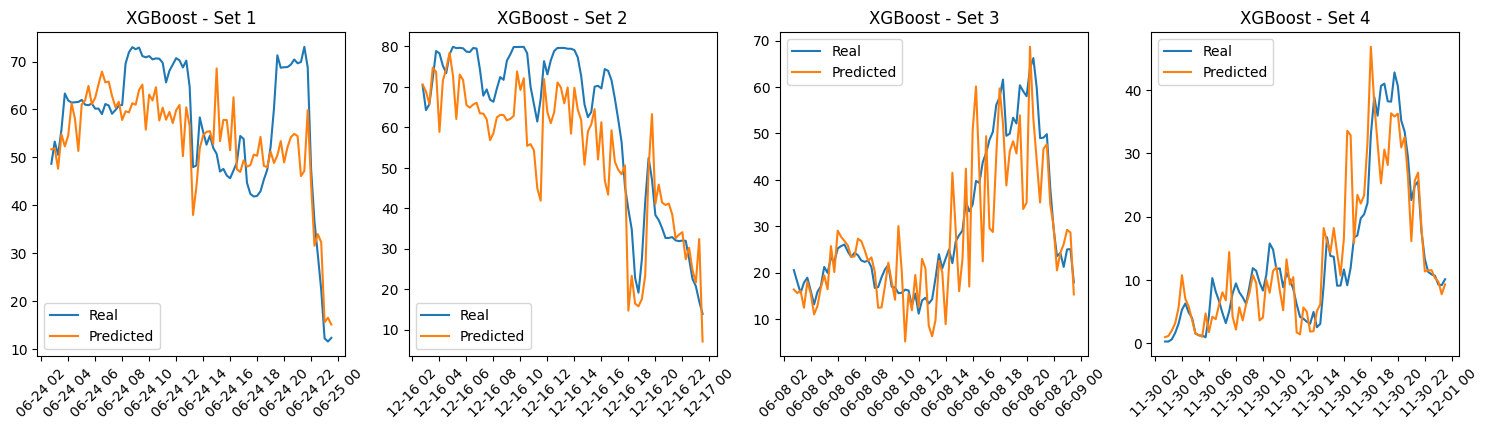

In [41]:
plt.figure(figsize=(15, 36))

# Plot XGBoost predictions for each dataset
plt.subplot(9, 4, 1)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_xgboost_1, label='Predicted')
plt.title('XGBoost - Set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 2)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_xgboost_2, label='Predicted')
plt.title('XGBoost - Set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 3)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_xgboost_3, label='Predicted')
plt.title('XGBoost - Set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 4)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_xgboost_4, label='Predicted')
plt.title('XGBoost - Set 4')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()